# Quelle est la meilleure destination pour prendre l’avion de Paris ?

*Bonneau-Chloup Hélène & Brahmi Laura*

Nous souhaitons étudier les prix des billets d’avions au départ de Paris à destination des plus grandes villes du monde (Londres, New-York, Tokyo …). Pour cela, nous allons utiliser les prix des vols disponibles sur le site de Kayak (webscraping), distinguer les compagnies low-cost des compagnies traditionnelles, horaire de départ, escales… Mais aussi la date de départ qui sera le paramètre de notre programme final qui donnera en sortie : 
- la destination la moins chère de façon absolue
- la destination la moins chère par kilomètre parcouru 

pour les compagnies “low cost” et les compagnies “traditionnelles” en prenant des allers simples au départ d’un des trois aéroports de Paris selon Kayak : Paris Orly, Paris Charles de Gaulle et l’aéroport de Beauvais.

Nous chercherons ainsi à savoir si le prix des billets d’avion dépend de la distance parcourue entre la ville de départ et la ville d’arrivée. Nous représenterons une partie de nos résultats à travers une carte du monde qui illustrera les prix les moins chers au départ de Paris à une date donnée.

Afin de voir les différents déterminants du prix d’un billet d’avion, nous réaliserons également des régressions linéaires du prix en fonction de la distance, des horaires, des escales, des bagages, du type de la compagnie : low-cost ou traditionnelle, des émissions de CO2…


## Table des matières
1. [Création de notre base de données](#paragraphe1)
    1. [Scraper Kayak](#subparagraphe11)
      1. [Scraping avec BeautifulSoup](#subsubparagraphe111)
      2. [Scraping avec Sélénium](#subsubparagraphe112)
      3. [Utiliser un API](#subsubparagraphe113)
    2. [Récupération des autres jeux de données](#subparagraphe12)
      1. [1ère méthode : scrapping avec Selenium](#subsubparagraphe121)
      2. [2ème méthode : calcul avec les coordonnées géographiques](#subsubparagraphe122)
2. [Statistiques descriptives](#paragraphe2)
  1. [Prix des vols en fonction de la destination (à date donnée : du 01/02 au 01/03)](#subparagraphe21)
  2. [Prix des vols en fonction de la date (à destination donnée : Londres)](#subparagraphe22)
3. [Modélisation](#paragraphe3)
  1. [Corrélation entre prix et distance](#subparagraphe31)
  2. [ACP](#subparagraphe32)
3. [Visualisation](#paragraphe4)
4. [Conclusion]



## Création de notre base de données <a name = "paragraphe1"></a>

Pour notre projet nous avons besoin de différents jeux de données : 
- une liste des aéroports les plus importants du monde
- la distance entre Paris et ces aéroports
- une liste des compagnies aériennes "low cost" et "traditionnelles"
- une liste de dates intéressantes (fêtes, jours fériés, vacances...) pour prendre en compte ces périodes lors de notre analyse des prix des vols
- des données provenant de Kayak : pour chaque vol, obtenir son pix, sa companie aérienne, l'horaire du vol, le nombre de bagages autorisés, le nombre d'escales, les émissions de $CO_2$ de ce vol...


### Scraper Kayak <a name = "subparagraphe11"></a>



On veut récupérer les données de cette page :

In [17]:
url = 'https://www.kayak.fr/flights/PAR-MAD/2022-02-01?sort=price_a'

Cette page présente les vols à départ de Paris et à destination de Madrid le $1^{er}$ février 2022 pour un aller simple pour une personne adulte. C'est ce genre de vols qu'on retient à priori :    
- un aller-simple
- pour une personne adulte 
- à départ de Paris 
- à destination variable (mais pour commencer le scraping, on fixe la destination à Madrid)
- à date variable (mais pour commencer le sraping, on fixe la date au $1^{er}$ février)

Nous avons rencontré des problèmes lorsque nous avons voulu récupérer des données de Kayak, avec BeautifulSoup, puis avec Sélénium. Nous n'avons pas réussi à trouver une classe qui nous intéresse ('section duration allow-multi-modal-icons'), quelque soit la technique de scraping utilisée. Cette classe est utilisée comme exemple pour montrer que nous n'avons pas réussi à avoir accès aux données de Kayak de cette façon là. Elle renvoie aux durées des vols.

Si on ouvre la page et qu'on regarde le code source, on trouve que 'section duration allow-multi-modal-icons' est un nom de classe qui mène directement aux temps de trajet. Le problème est que nous n'arrivons pas à retrouver cette classe avec BeautifulSoup ou Sélénium.

(On peut parler que Kayak fait en sorte que ce soit difficile à scrapper. Par exemple le Xpath du prix d'un billet varie à chaque connexion sur le site, pour éviter de webscrapper) 

#### Scraping avec BeautifulSoup <a name = "subsubparagraphe111"></a>

In [ ]:
!pip install lxml

In [794]:
import urllib
import bs4
from urllib import request

In [795]:
req = urllib.request.Request(url,headers={'User-Agent':'Mozilla/5.0'})
html = urllib.request.urlopen(req).read()
page = bs4.BeautifulSoup(html, "lxml")

In [796]:
page.findAll('div',{'class':"section duration allow-multi-modal-icons"})


[]

In [797]:
elem = page.select(".section duration allow-multi-modal-icons")
print(elem)

[]


Les listes renvoyées sont toujours vides, alors que ce nom de classe existe bien. En allant voir le code source de la page et en recherchant 'section duration allow-multi-modal-icons', on trouve plusieurs occurences de cette classe.

#### Scraping avec Sélénium <a name = "subsubparagraphe112"></a>

In [772]:
!pip install selenium

In [773]:
!pip install webdriver-manager

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7




We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

selenium 4.1.0 requires urllib3[secure]~=1.26, but you'll have urllib3 1.25.11 which is incompatible.


In [5]:
import selenium
from selenium import webdriver
#from webdriver_manager.chrome import ChromeDriverManager  moi je n'ai pas besoin de cette ligne pour le driver

from time import sleep
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome import options
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import ChromeOptions
from selenium.common.exceptions import NoSuchElementException

Les commandes suivantes ne fonctionnent pas sur Google Colab, mais uniquement en local, d'où la mise en commentaire.

In [ ]:
#driver = webdriver.Chrome(ChromeDriverManager().install())

In [ ]:
#driver.get(url)

In [ ]:
#driver.find_elements_by_xpath('//*[@class="section duration allow-multi-modal-icons"]')

La commande ci-dessus renvoie en local cette liste, que nous n'avons pas réussi à exploiter :
```
[<selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="2c68fde4-ad59-4559-9b22-a08f7e6ade1e")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="525b1216-b4b8-4584-8e49-ff45cf58911f")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="476e6118-d09a-410c-b0d2-a77ae80500a0")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="569687cd-39d8-4b13-9ce2-57b771a696e7")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="388dae26-dfbe-4d97-aeff-79daf12231bb")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="c146388e-4593-42a9-8d48-f4467767d74e")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="51a25ea2-bce5-4681-8b33-4d29a43e1d4c")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="1dbe58c2-6a9c-4374-89c0-2011936401e1")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="328e7dcc-272b-47b4-b0de-bcfa01ce4b0d")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="1a81c680-0d13-4707-82b4-e6638c28e912")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="6f0d9f2e-19c1-4d2e-a5a4-061a72cdcfba")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="2910048d-6f7b-41d3-a060-1e36c3a3798b")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="828030ac-e40d-44f8-b572-ae9173930073")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="6fe3182c-61b2-4dc7-a8cb-73a6adcf3b03")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="db160b2f-aa64-4571-8c66-65e601518262")>]
```

In [6]:
driver = webdriver.Chrome(executable_path="D:/ENSAE/2A 2020 2021/S1/Python data science/chromedriver.exe")
driver.get(url) #ouverture de la page kayak mais il y a une fenêtre de cookies qui s'ouvre, il faut accepter ou refuser 

<ipython-input-6-123cad5b2b15>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path="D:/ENSAE/2A 2020 2021/S1/Python data science/chromedriver.exe")


Quand on ouvre la page kayak, il y a une fenêtre de cookie qui s'ouvre. On la ferme pour pouvoir accéder au site.

In [7]:
#xp_close='//*[@id="Poxk-accept"]'
#driver.find_elements_by_xpath(xp_close).click()

driver.find_element_by_class_name("_ixe").click() #pour fermer la page de cookies

<ipython-input-7-561bc4745d71>:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_class_name("_ixe").click() #pour fermer la page de cookies


Avec ce code on arrive à obtenir le prix d'un billet d'avion, mais on n'arrive pas à trouver un même chemin pour tous les vols afin d'obtenir une liste de prix. En effet, le chemin d'un prix change à chaque connexion. Cela semble être une technique de kayak pour éviter le scrapping.

In [803]:
xp_prices = '//*[@id="T0bh-mb-aE-16e12409bb1-price-text"]'
#xp_prices = '//a[@class="booking-link"]/span[@class="price option-text"]' chemin qui serait valable pour tous les prix ?
prices = driver.find_elements_by_xpath(xp_prices)
prices_list = [price.text.replace('€','') for price in prices if price.text != '']

<ipython-input-803-31d1f63304fa>:3: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  prices = driver.find_elements_by_xpath(xp_prices)


In [718]:
prices_list

['28 ']

#### Utiliser un API <a name = "subsubparagraphe113"></a>

Nous avons ensuite pensé à utiliser un API, ce qui nous a permis d'obtenir ce code et d'avoir enfin une base de données de Kayak exploitable.

In [111]:
import requests
import pandas as pd

pd.set_option('display.max_columns', 500)

url = "https://www.kayak.com/s/horizon/exploreapi/destinations?airport=PAR&budget=&depart=20220201&return=20220301&duration=&exactDates=true&flightMaxStops=&stopsFilterActive=false&topRightLat=59.902761633461935&topRightLon=25.09658365167229&bottomLeftLat=26.101275008286677&bottomLeftLon=-6.719822598327707&zoomLevel=4&selectedMarker=&themeCode=&selectedDestination="
req = requests.get(url)
out = req.json()
df = pd.json_normalize(out["destinations"])


**Remarque : l'API a changé je reprends l'ancienne**


In [114]:
df.to_csv('D:/ENSAE/2A 2020 2021/S1/Python data science/dataframe_projet_python_01-02_01-03.csv')

In [115]:
df.columns
df.head(2)

,days,originAirportShortName,departd,returnd,airline,airlineCode,airlineIcon,clickoutUrl,flightMaxStops,flightMaxDuration,relevancyScore,travelRestrictionInfo,flightInfo.price,flightInfo.localizedPrice,flightInfo.priceUSD,flightInfo.historicalPrice,flightInfo.priceless,flightInfo.predicted,flightInfo.url,airport.latitude,airport.longitude,airport.name,airport.popularity,airport.shortName,city.id,city.name,city.image,country.code,country.name,flightInfo.historicPrices
0,28,CDG,20220201,20220301,Multiple Airlines,None,https://content.r9cdn.net/rimg/provider-logos/...,/flights/PAR-NYC/2022-02-01/2022-03-01/,0,9999999,1000,None,322.97,$323,322.97,None,False,True,None,40.75096,-73.98741,None,85682,NYC,15830,New York,None,US,United States,NaN
1,28,LBG,20220201,20220301,Multiple Airlines,None,https://content.r9cdn.net/rimg/provider-logos/...,/flights/PAR-NYC/2022-02-01/2022-03-01/,0,9999999,1000,None,805.06,$805,805.06,None,False,True,None,40.75096,-73.98741,None,85682,NYC,15830,New York,None,US,United States,NaN


Le dataframe obtenu par cette méthode est riche mais nous a obligées à revoir nos objectifs. 

- Nous n'avons pas accès aux companies aériennes, la plupart étant regroupées dans le terme 'Multiple Airlines' (14827 occurences sur 14882). Donc nous ne pourrons pas distinguer selon les companies aériennes dans la suite de notre projet. 

In [116]:
df['airline'].value_counts()

Multiple Airlines      14733
Air Austral               19
Air France                 9
Vipper                     6
Air Canada                 5
United Airlines            3
Finnair                    2
Brussels Airlines          2
Iberia                     2
Corsair                    2
Turkish Airlines           2
Qatar Airways              2
TAP AIR PORTUGAL           2
American Airlines          2
Air Algerie                2
Emirates                   2
easyJet                    1
KLM                        1
Icelandair                 1
Etihad Airways             1
French Bee                 1
Belavia                    1
Wizz Air                   1
British Airways            1
LATAM Airlines             1
La Compagnie               1
Delta                      1
Kenya Airways              1
Singapore Airlines         1
Pegasus Airlines           1
Air Caraïbes               1
ASL Airlines France        1
Ryanair                    1
Name: airline, dtype: int64

* Nous nous intéressons donc seulement aux vols de 'Multiple Airlines'

In [117]:
df=df[df['airline']=='Multiple Airlines']

- Nous n'avons pas accès au nombre de bagages, ni aux horaires des vols, ni au nombre d'escales (de la même façon que pour les compagnies aérinnes, la très grande majorité est sans escale), et ni aux émissions de $CO_2$ du vol.

- Nous avons uniquement accès à des vols aller-retour, donc nous nous baserons sur des voyages d'un mois, en partant tous les $1^{er}$ du mois, de février à novembre inclus.

La colonne 'flightMaxStop' correspond au nombre d'escale. On remarque que la plupart des vols se font sans escale

In [118]:
df['flightMaxStops'].value_counts()

0    14710
2       12
1        6
3        5
Name: flightMaxStops, dtype: int64

Par la suite, nous considérerons tous les vols sans escale.

In [119]:
df=df[df['flightMaxStops']==0]

On ne garde que les colonnes qui nous intéressent pour la suite.

Remarque Hélène : je pense qu'on peut en enlever davantage

In [122]:
df=df[['originAirportShortName','departd','returnd','airline',
     'flightInfo.price','flightInfo.localizedPrice','flightInfo.priceUSD','flightMaxStops',
    'airport.latitude','airport.longitude','airport.shortName','city.name','country.name']]
df.head(2) 

,originAirportShortName,departd,returnd,airline,flightInfo.price,flightInfo.localizedPrice,flightInfo.priceUSD,flightMaxStops,airport.latitude,airport.longitude,airport.shortName,city.name,country.name
0,CDG,20220201,20220301,Multiple Airlines,322.97,$323,322.97,0,40.75096,-73.98741,NYC,New York,United States
1,LBG,20220201,20220301,Multiple Airlines,805.06,$805,805.06,0,40.75096,-73.98741,NYC,New York,United States


In [120]:
sum(df['flightInfo.price']==df['flightInfo.priceUSD'])

14710

In [121]:
df.shape

(14710, 30)

On remarque que 'flightInfo.price' et 'flightInfo.priceUSD' sont les mêmes donc on peut garder une seule des deux variables. 

In [123]:
df=df[['originAirportShortName','departd','returnd','airline',
     'flightInfo.priceUSD','flightMaxStops',
    'airport.latitude','airport.longitude','airport.shortName','city.name','country.name']]

Pour nous assurer de pouvoir utiliser cette base de données au cas où Kayak bloquerait nos appels, on enregistre cette première base.

(De la même manière que tout à l'heure, cette commande est mise en commentaire car elle ne fonctionne qu'en local.)

In [ ]:
#df.to_csv('dataframe_projet_python_01/02_01/03.csv')

### Récupération des autres jeux de données <a name = subparagraphe12></a>

D'après ce qui a été vu ci-dessus récupérer une liste des compagnies aériennes "lowcost" et "traditionnelles" n'est plus utile.

Pour la liste de dates, nous retenons celle-là : 
* Lundi de Pâques : lundi 18/04/2022
* Fête du travail : dimanche 01/05/2022
* Armistice de 1945 : dimanche 08/05/2022 
* Ascension : jeudi 26/05/2022
* Lundi de Pentecôte : lundi 06/06/2022
* Fête nationale : jeudi 14/07/2022
* Assomption : lundi 15/08/2022
* Toussaint : mardi 01/11/2022
* Armistice de 1918 : vendredi 11/11/2022






Ainsi que la date des vacances scolaires en France ? (Tu ne l'avais pas mis ça je ne sais pas si tu les utilises)

* hiver : 
    * Zone A = samedi 12/02/2022 au lundi 28/02/2022, Zone B = samedi 05/02/2022 au lundi 21/02/2022, Zone C = samedi 19/02/2022 au lundi 07/03/2022 
* printemps : 
    * Zone A = samedi 16/04/2022 au lundi 02/05/2022, Zone B = samedi 09/04/2022 au lundi 24/04/2022, Zone C = samedi 23/04/2022 au lundi 09/05/2022
* été : 
    * jeudi 07/07/2022 


Au vu de la base de données de Kayak obtenue, nous décidons d'utiliser une liste de villes à la place d'une liste d'aéroports. Nous retenons cette liste de ?? (j'ai rajouté d'autres) villes :
* Abidjan
* Agadir
* Alger
* Amman
* Amsterdam
* Antalya
* Athènes
* Bangkok
* Barcelone
* Berlin
* Bogota
* Bombay
* Boston
* Budapest
* Buenos-Aires
* Canberra
* Caracas
* Casablanca
* Chicago
* Colombo
* Copenhague
* Dakar
* Delhi
* Djerba
* Djibouti
* Dubaï
* Dublin
* Edimbourg
* Francfort
* Helsinki
* Hong-Kong
* Houston
* Istanbul
* Jakarta
* Johannesburg
* Kuala Lumpur
* Le Caire
* Lisbonne
* Montréal
* New-York
* Los Angeles
* Sydney
* Rome
* Tokyo
* Rio de Janeiro
* .......

Pour ce qui est de la distance entre Paris et les villes en questions, nous avons procédé de deux façons différentes.

#### 1ère méthode : scrapping avec Selenium <a name = "subsubparagraphe121"></a>

Les distances sont scrappées à partir d'un site internet. La ville de départ et la ville d'arrivée sont à indiquer et la distance entre ces deux villes nous est communiquée. Nous avons choisi Paris comme ville de départ et une liste est créée avec les distances entre Paris et les ?? villes citées plus haut.

In [15]:
import re 
import numpy as np
import pandas as pd

In [124]:
options = webdriver.ChromeOptions()
options.add_argument("private")
options.add_argument("--start-maximized");
options.add_argument("--ignore-certificate-errors");
options.add_argument("--disable-popup-blocking");
options.add_argument("--incognito");
options.add_argument("--headless");


driver = webdriver.Chrome(executable_path="D:/ENSAE/2A 2020 2021/S1/Python data science/chromedriver.exe",options=options)

distances=[]
villes=["Abidjan","Agadir","Alger","Amman","Amsterdam","Antalya","Athènes","Bangkok","Barcelone","Berlin","Bogota","Mumbai",
 "Boston","Budapest","Buenos-Aires","Canberra","Caracas","Casablanca","Chicago","Colombo","Copenhague","Dakar","Delhi",
 "Djerba","Djibouti","Dubaï","Dublin","Edimbourg","Francfort","Helsinki","Hong-Kong","Houston","Istanbul","Jakarta",
 "Johannesburg","Kuala Lumpur","Le Caire","Lisbonne","Montréal","New-York","Los Angeles","Sydney","Rome","Tokyo","Rio de Janeiro"]


driver.get('http://fr.distances-routieres.himmera.com/monde')

for ville in villes : 

    search_bar = driver.find_element_by_id("fr")
    search_bar=driver.find_element_by_id("fr").clear()
    search_bar = driver.find_element_by_id("fr")
    search_bar.send_keys("Paris")
    
    search_bar_bis = driver.find_element_by_id("to")
    search_bar=driver.find_element_by_id("to").clear()
    search_bar = driver.find_element_by_id("to")
    search_bar_bis.send_keys(ville+Keys.ENTER)


    element = driver.find_element_by_class_name("btq").click()
    distance = driver.find_element_by_class_name("t_mi").text
    distance=re.sub('KM','',distance)
    distance=re.sub(' ','',distance)
    distance=int(distance)
    distances.append(distance)
    
    
    driver.get('http://fr.distances-routieres.himmera.com/monde')

    
print(distances)

<ipython-input-124-47b99da7bbe3>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path="D:/ENSAE/2A 2020 2021/S1/Python data science/chromedriver.exe",options=options)
<ipython-input-124-47b99da7bbe3>:23: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_bar = driver.find_element_by_id("fr")
<ipython-input-124-47b99da7bbe3>:24: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_bar=driver.find_element_by_id("fr").clear()
<ipython-input-124-47b99da7bbe3>:25: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_bar = driver.find_element_by_id("fr")
<ipython-input-124-47b99da7bbe3>:28: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_bar_bis = driver.find_element_by_id("to")
<ipython-input-

[4878, 2288, 1347, 3368, 430, 2645, 2096, 9447, 831, 878, 8634, 0, 5533, 1244, 11053, 16924, 7621, 1889, 6653, 8518, 1027, 4198, 6574, 1815, 5535, 5247, 781, 874, 478, 1909, 9619, 8088, 2256, 11589, 8731, 10427, 3211, 1455, 5507, 5839, 9088, 16965, 1106, 9715, 9171]


On transforme la liste obtenue précédement en un dataframe 

In [125]:
list_dist=np.array([villes,distances]).T
df_dist=pd.DataFrame(list_dist)
df_dist.columns=['Ville','Distance à Paris (km)']
df_dist

,Ville,Distance à Paris (km)
0,Abidjan,4878
1,Agadir,2288
2,Alger,1347
3,Amman,3368
4,Amsterdam,430
5,Antalya,2645
6,Athènes,2096
7,Bangkok,9447
8,Barcelone,831
9,Berlin,878


#### 2ème méthode : calcul avec les coordonnées géographiques <a name = "subsubparagraphe122"></a>

On crée un fonction qui permet de calculer les distances entre deux villes à partir de leur latitude et longitude

In [126]:
from math import radians

def haversine(row):
    lon1 = 2.3473 
    lat1 = 48.85749
    lon2 = row['airport.longitude']
    lat2 = row['airport.latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = round(6367 * c)
    return km

On ajoute une colonne distance entre Paris et la ville correspondante

In [127]:
df['distance'] = df.apply(lambda row: haversine(row), axis=1)
df.head(2)

,originAirportShortName,departd,returnd,airline,flightInfo.priceUSD,flightMaxStops,airport.latitude,airport.longitude,airport.shortName,city.name,country.name,distance
0,CDG,20220201,20220301,Multiple Airlines,322.97,0,40.75096,-73.98741,NYC,New York,United States,5829
1,LBG,20220201,20220301,Multiple Airlines,805.06,0,40.75096,-73.98741,NYC,New York,United States,5829


La deuxième méthode sera privilégiée car le nom des villes dans le data frame sont en anglais. Par exemple il est indiqué "London" et non "Londres", or cela pose un problème avec le site utilisé pour scrapper les distances car il n'accepte que des noms français (je ne sais pas si c'est une bonne raison pcq on peut très bien utiliser un site en anglais pour résoudre le pb...)

## Statistiques descriptives <a name = "paragraphe2"></a>

### Prix des vols en fonction de la destination (à date donnée : du 01/02 au 01/03) <a name = "subparagraphe21"></a>

On s'intéresse aux vols au départ des aéroports de Roissy-Charles de Gaulles (CGD) et de Orly (ORY). On laisse de côté les aéroports Paris-Le Bourget (LBG), Paris-Vatry (XCR) et Beauvais (BVA). Un nouveau dataframe **df_paris** est crée

In [128]:
df_paris=df.loc[df['originAirportShortName'].isin(['CDG','ORY'])]

Dans la colonne des prix, il y a des prix non renseignés notés en **'999999.0'** on les remplace par des **0**

In [130]:
df_paris.loc[df_paris['flightInfo.priceUSD']== 999999.0] = 0 

C:\Users\Laura\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Dans le dataframe, le nom des villes est en anglais. On crée donc une liste de villes avec des noms en anglais

In [179]:
villes_en=["Agadir","Amsterdam","Antalya","Athens","Bangkok","Barcelona","Berlin","Mumbai",
           "Boston","Budapest","Canberra","Casablanca","Chicago","Colombo","Copenhagen","Oslo","Dubai",
           "New Delhi","Tunis","Djibouti","Dublin","Edinburgh","Helsinki","Hong Kong","Houston","Jakarta",
           "Johannesburg","Kuala Lumpur","Cairo","Lisbon","Montreal","New York","Rome","Tokyo",
           "Lagos",'Port Louis',"Nairobi","Moscow","Hanoi","London", "Rio de Janeiro","Liberia",
           "Guadalajara","Auckland","Concepción", "Izmir","Chicago"]


Il y a certaines grandes villes qui apparaissent dans plusieurs pays. Par exemple, il y a Rome en Italie et Rome aux Etats-Unis. Ces villes ne seront donc pas prises en compte. Il y a par exemple Buenos Aires (Argentine et Costa Rica), Sydney (Autralie et Canada)

In [169]:
df_paris[df_paris['city.name']=="Rome"]['country.name'].value_counts()

Italy            6
United States    2
Name: country.name, dtype: int64

In [249]:
#df_paris[df_paris['country.name']=="Ecuador"]

**Calcul du prix moyen d'un billet**

In [183]:
prix_moyen=[]
nb=[]
dist=[]
for ville in villes_en : 
    p=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].astype(int).mean()
    nbr=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].count()
    distance=df_paris[df_paris['city.name']==ville]['distance'].iloc[0]
    dist.append(distance)
    nb.append(nbr)
    prix_moyen.append(round(p))
    

#### On crée une liste de pays correspondant avec les villes sélectionnées

In [184]:
pays=[]
for ville in villes_en:
    pays.append(df_paris[df_paris['city.name']==ville]['country.name'].iloc[0])

#### Création d'un dataframe avec le prix et les villes 

In [185]:
list_prix=np.array([villes_en,pays,dist,prix_moyen,nb]).T
df_prix=pd.DataFrame(list_prix)
df_prix.columns=['Ville','Pays','Distance à Paris (km)','Prix moyen du vol en $','Nombre de vol']
df_prix['Prix moyen du vol en $']=df_prix['Prix moyen du vol en $'].astype(str).astype(int)
df_prix.sort_values(by=['Prix moyen du vol en $']) #prix trié de façon croissante


,Ville,Pays,Distance à Paris (km),Prix moyen du vol en $,Nombre de vol
9,Budapest,Hungary,1261,42,2
5,Barcelona,Spain,840,49,2
29,Lisbon,Portugal,1447,54,2
6,Berlin,Germany,876,66,2
20,Dublin,Ireland,785,66,2
21,Edinburgh,United Kingdom,878,74,2
14,Copenhagen,Denmark,1026,90,2
1,Amsterdam,Netherlands,420,96,2
3,Athens,Greece,2113,112,2
15,Oslo,Norway,1378,112,4


Remarque : Certaines destinations sont présentes proposée que via un vol. Par exemple, il n'y a qu'un vol pour Amman au départ de Paris. Le calcul du prix moyen pour ces destinations n'a donc pas un très grand sens. 

On importe un fichier **.xlsx** qui contient une liste de pays avec leur continent. Cela permettra d'indiquer dans le dataframe précédent le continent pour chaque pays. 

In [186]:
df_cont=pd.read_excel("D:/ENSAE/2A 2020 2021/S1/Python data science/pays_continent.xlsx")
df_prix_cont=df_prix.merge(df_cont,on='Pays')
df_prix_cont['Continent'].value_counts()

Europe           13
Asia             11
Africa            9
North America     8
Oceania           2
South America     2
Name: Continent, dtype: int64

Il y a très peu de pays représentés en Océanie, ou en Amériquer du Sud. Les destinations de notre base de données sont principalement situées en Europe, Asie ou Afrique.

### Réalisation de graphiques

<AxesSubplot:title={'center':'Prix moyen du vol en $ au départ de Paris'}, xlabel='Villes', ylabel='Prix aller-retour'>

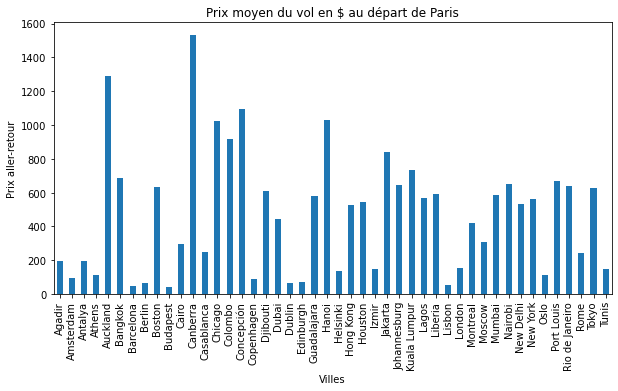

In [192]:
import matplotlib.pyplot as plt 

df1=df_prix.groupby("Ville").sum()['Prix moyen du vol en $']
df1.plot(kind = "bar",xlabel="Villes",ylabel="Prix aller-retour",title="Prix moyen du vol en $ au départ de Paris",figsize=(10, 5))
# remarque : il y a peut être un peu trop de ville, ce n'est pas très lisible 

Les prix les moins chers au départ de Paris sont à destination de villes d'Europe (ex: Budapest, Barlecone, Dublin, Berlin ...). Canberra est la destination dont le prix moyen est le plus cher 1573 \$  au départ de Roissy Charles de Gaulle ou d'Orly. Budapest est la destination la moins chère avec un aller retour en moyenne qui coûte 49 \$. Ces prix moyens ne reflètent pas nécessairement la réalité car il y a très peu d'effctif pour avoir des résultats significatifs. 

<AxesSubplot:title={'center':'Les 10 villes dont le prix est le moins cher au départ de Paris'}, xlabel='Villes', ylabel='Prix aller-retour'>

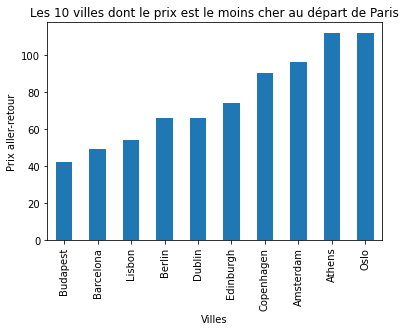

In [193]:
df2=df_prix.groupby("Ville").sum()['Prix moyen du vol en $'].sort_values(ascending=True)
df2.head(10).plot(kind = "bar",xlabel="Villes",ylabel="Prix aller-retour",title="Les 10 villes dont le prix est le moins cher au départ de Paris")

Les 10 destinations les moins chères sont situées en Europe. 

<AxesSubplot:title={'center':'Les 10 villes dont le prix est le plus cher au départ de Paris'}, xlabel='Villes', ylabel='Prix aller-retour'>

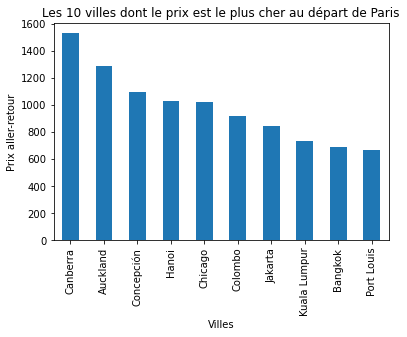

In [194]:
df3=df_prix.groupby("Ville").sum()['Prix moyen du vol en $'].sort_values(ascending=False)
df3.head(10).plot(kind = "bar",xlabel="Villes",ylabel="Prix aller-retour",title="Les 10 villes dont le prix est le plus cher au départ de Paris")

Les 10 villes les plus chères se situent au niveau de tous les continents sauf l'Europe. Les deux destinations les plus chères (Canberra et Auckland) sont situées en Océanie. 

**On s'intéresse plus spécifiquement à des villes aux Etats-Unis : New York, Los Angeles, Miami, Las Vegas**

In [196]:
villes_usa=["New York","Chicago","Miami","Las Vegas"]

prix_moyen_USA=[]
nb_usa=[]
dist_usa=[]
for ville in villes_usa : 
    p=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].astype(int).mean()
    nbr=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].count()
    distance=df_paris[df_paris['city.name']==ville]['distance'].iloc[0]
    nb_usa.append(nbr)
    dist_usa.append(distance)
    prix_moyen_USA.append(round(p))


In [197]:
list_prix_usa=np.array([villes_usa,prix_moyen_USA,dist_usa,nb_usa]).T
df_prix_usa=pd.DataFrame(list_prix_usa)
df_prix_usa.columns=['Ville','Prix moyen du vol en $','Distance à Paris (km)','Nombre de vol']
df_prix_usa['Prix moyen du vol en $']=df_prix_usa['Prix moyen du vol en $'].astype(str).astype(int)
df_prix_usa.sort_values(by=['Prix moyen du vol en $'])

,Ville,Prix moyen du vol en $,Distance à Paris (km),Nombre de vol
2,Miami,373,7356,2
1,Chicago,511,6656,8
0,New York,562,5829,4
3,Las Vegas,645,8732,4


New-York est la ville américaine la plus desservie au départ de Paris. 6 vols sont proposés pendant la période étudiée.

<AxesSubplot:title={'center':'Prix moyen du vol en $ au départ de Paris'}, xlabel='Villes américaines', ylabel='Prix aller-retour'>

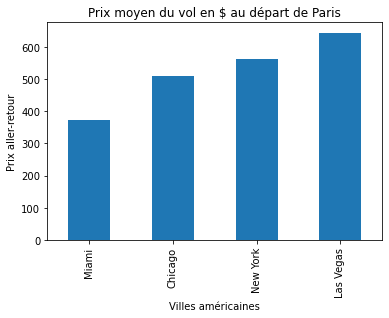

In [198]:
df1=df_prix_usa.groupby("Ville").sum()['Prix moyen du vol en $'].sort_values()
df1.plot(kind = "bar",xlabel="Villes américaines",ylabel="Prix aller-retour",title="Prix moyen du vol en $ au départ de Paris")

Miami est la ville dont le prix moyen aller-retour de Paris est le moins cher (373 $), mais ce n'est pas la ville qui est la plus proche de Paris. Elle se trouve à 7356 km alors que New-York est à 5829 km. On peut se demander s'il existe une corrélation entre le prix et la distance.


### Prix des vols en fonction de la date (à destination donnée : Londres) <a name = "subparagraphe22"></a>

Nous allons maintenant nous intéresser au prix des vols par rapport aux dates du voyage. Nous considérons ici les départsAu départ de tous les aéroports de Paris confondus

In [199]:
df.value_counts("city.name") 

city.name
London         40
Stockholm      25
Moscow         25
Columbus       20
Georgetown     20
               ..
Parkersburg     5
Parintins       5
Parikia         5
Pardubice       5
A Coruña        5
Length: 2748, dtype: int64

On remarque que Londres est la ville la plus désservie, c'est donc celle-ci qu'on choisit pour étudier le prix des vols selon la période de l'année.

On crée une fonction qui renvoie la base de données réduite à Londres pour une date de départ et une date de retour données.

In [200]:
def df_lon(dat1,dat2):
  pd.set_option('display.max_columns', 500)
  url = "https://www.kayak.com/s/horizon/exploreapi/destinations?airport=PAR&budget=&depart="+dat1+"&return="+dat2+"&duration=&exactDates=true&flightMaxStops=&stopsFilterActive=false&topRightLat=59.902761633461935&topRightLon=25.09658365167229&bottomLeftLat=26.101275008286677&bottomLeftLon=-6.719822598327707&zoomLevel=4&selectedMarker=&themeCode=&selectedDestination="
  req = requests.get(url)
  out = req.json()
  dfl = pd.json_normalize(out["destinations"])
  dfl.head()
  dfl = dfl[dfl["city.name"]=="London"]
  dfl.loc[dfl['flightInfo.price']== 999999.0] = 0 #certains prix sont normalisés à 999999.0 -> on les ramène à 0
  return dfl


On crée une liste de dates qui correspondent aux mois de l'année.

In [201]:
dates=["20220201","20220301","20220401","20220501","20220601","20220701","20220801","20220901","20221001","20221101","20221201"]

dates_utiles=["20220418","20220501","20220508","20220526","20220606","20220714","20220815","20221101","20221111","20220212","20220205","20220219","20220409","20220416","20220423","20220707"]
#jours fériés et début des vacances scolaires pour chaque zone

On crée une liste de prix moyens en utilisant la liste de dates et la fonction df_lon.

In [202]:
lon_prix=[]
for i in range(10):
  dfd = df_lon(dates[i],dates[i+1])
  prix = dfd["flightInfo.price"].mean()
  lon_prix.append(prix)

On crée une liste des mois correspondant à la liste de dates précédente.

In [203]:
mois=["février","mars","avril","mai","juin","jullet","août","septembre","octobre","novembre"]

On construit un dataframe avec les dates, les prix et le mois.

In [204]:
df_prix_london=pd.DataFrame(dates[:10], columns=["dates"])
df_prix_london["prix"]=lon_prix
df_prix_london["mois"]=mois

On affiche les résulats.

<AxesSubplot:title={'center':"Prix moyen d'un vol Paris-Londres en $"}, xlabel="Mois de l'année", ylabel="Prix pour un voyage d'un mois">

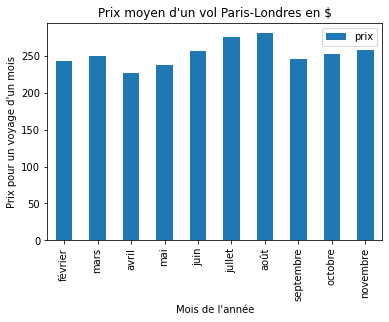

In [205]:
df_prix_london.plot(x="mois",y="prix",kind = "bar",xlabel="Mois de l'année",ylabel="Prix pour un voyage d'un mois",title="Prix moyen d'un vol Paris-Londres en $")

Commentaires à faire... 

On voit un pic de prix pendant les vacances d'été (en juillet le prix est le plus élevé)



## Modélisation <a name = "paragraphe3"></a>

### Corrélation entre prix et distance <a name = "subparagraphe31"></a>

In [208]:
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import numpy as np

In [209]:
df_reg=df_prix.loc[:,["Prix moyen du vol en $","Distance à Paris (km)"]]

#### Régression linéaire 
On effectue une régression linéaire avec toutes les villes de la base de données

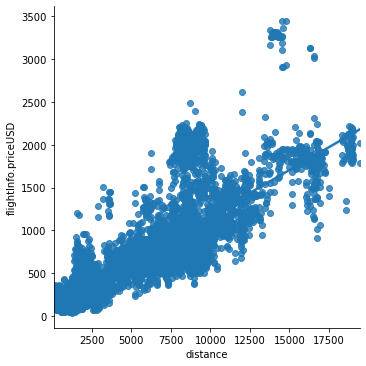

In [211]:
sns.lmplot(x="distance", y="flightInfo.priceUSD", data=df_paris)

On remarque que pour les faibles distances le modèle est assez linéaire, alors que pour les grandes distances les prix sont très variables. Il y a une corrélation positive entre le prix et la distance.

* On trace un nuage de points avec les villes qu'on a sélectionnées précédemment (celles de la liste **villes_en**)

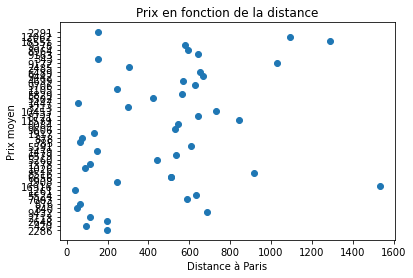

In [212]:
#sns.lmplot(x="Distance à Paris (km)", y="Prix moyen du vol en $", data=df_prix) 
#ça ne marche pas bizarre, peut être parce que on regarde les prix moyens ??
plt.scatter(df_prix['Prix moyen du vol en $'],df_prix['Distance à Paris (km)'])
plt.xlabel('Distance à Paris')
plt.ylabel('Prix moyen')
plt.title('Prix en fonction de la distance')
plt.show()


* On regroupe les résultats par continents 

In [213]:
df_africa=df_prix_cont[df_prix_cont['Continent']=='Africa']
df_europe=df_prix_cont[df_prix_cont['Continent']=='Europe']
df_oceania=df_prix_cont[df_prix_cont['Continent']=='Oceania']
df_asia=df_prix_cont[df_prix_cont['Continent']=='Asia']
df_namerica=df_prix_cont[df_prix_cont['Continent']=='North America']
df_samerica=df_prix_cont[df_prix_cont['Continent']=='South America']


df_africa=df_africa[['Distance à Paris (km)','Prix moyen du vol en $']]
df_europe=df_europe[['Distance à Paris (km)','Prix moyen du vol en $']]
df_oceania=df_oceania[['Distance à Paris (km)','Prix moyen du vol en $']]
df_asia=df_asia[['Distance à Paris (km)','Prix moyen du vol en $']]
df_namerica=df_namerica[['Distance à Paris (km)','Prix moyen du vol en $']]
df_samerica=df_samerica[['Distance à Paris (km)','Prix moyen du vol en $']]


* On réalise un nuage de points en distinguant chaque contient 

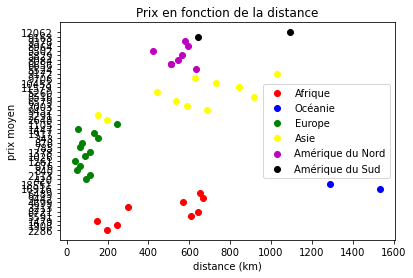

<Figure size 360x3600 with 0 Axes>

In [221]:
#df_africa.plot(kind='scatter' ,x='distance', y='prix', color='DarkBlue', label='Group 1')

plt.scatter(df_africa['Prix moyen du vol en $'],df_africa['Distance à Paris (km)'], c='Red', label='Afrique')
plt.scatter(df_oceania['Prix moyen du vol en $'],df_oceania['Distance à Paris (km)'], c='Blue',label='Océanie')
plt.scatter(df_europe['Prix moyen du vol en $'],df_europe['Distance à Paris (km)'], c='Green',label='Europe')
plt.scatter(df_asia['Prix moyen du vol en $'],df_asia['Distance à Paris (km)'], c='Yellow',label='Asie')
plt.scatter(df_namerica['Prix moyen du vol en $'],df_namerica['Distance à Paris (km)'], c='m',label='Amérique du Nord')
plt.scatter(df_samerica['Prix moyen du vol en $'],df_samerica['Distance à Paris (km)'], c='k',label='Amérique du Sud')

plt.xlabel('distance (km)')
plt.ylabel('prix moyen')
plt.legend()
plt.title('Prix en fonction de la distance')
plt.show()

Deux groupes se distinguent : l'un avec l'Europe, l'Asie, l'Amérique du Nord et l'Amérique du Sud, l'autre avec l'Afrique et l'Océanie. Il serait peut être intéressant de faire deux régressions linéaires (à voir si j'ai le temps de le faire).

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

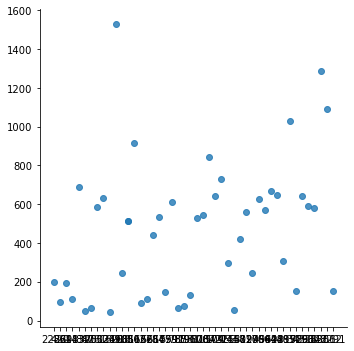

In [223]:
df_afr_oce=df_prix_cont.loc[df_prix_cont['Continent'].isin(['Africa','Oceania'])]
df_autre_contient=df_prix_cont.loc[df_prix_cont['Continent'].isin(['North America','South America','Europe','Asia'])]

sns.lmplot(x="Distance à Paris (km)", y="Prix moyen du vol en $",data=df_prix) 


In [250]:
df_africa['Prix moyen du vol en $'].astype(str).astype(int)
df_africa['Distance à Paris (km)'].astype(str).astype(int)

#sns.lmplot(x="Distance à Paris (km)", y="Prix moyen du vol en $",hue='Continent',data=df_prix_cont) 


0     2286
1     1908
22    1479
23    5591
29    8721
31    3213
36    4699
37    9442
38    6489
Name: Distance à Paris (km), dtype: int32

**Régression linéaire avec statsmodels**

In [251]:
X = df_paris[["distance"]]
y = df_paris["flightInfo.priceUSD"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# dans cette sortie il n'y a pas de constante ... bizarre 

                                 OLS Regression Results                                 
Dep. Variable:     flightInfo.priceUSD   R-squared (uncentered):                   0.880
Model:                             OLS   Adj. R-squared (uncentered):              0.880
Method:                  Least Squares   F-statistic:                          4.314e+04
Date:                 Tue, 04 Jan 2022   Prob (F-statistic):                        0.00
Time:                         00:12:37   Log-Likelihood:                         -42709.
No. Observations:                 5884   AIC:                                  8.542e+04
Df Residuals:                     5883   BIC:                                  8.543e+04
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Toutes choses égales par ailleurs, si la distance à Paris augmente de 1km, le prix du billet d'avion augmente de 0,12 dollars.
Le $R^{2}$ est assez bon

In [252]:
X = df_paris[["distance"]]
y = df_paris["flightInfo.priceUSD"]
X = sm.add_constant(X) #ici on ajoute
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

#j'ai trouvé ça sur le site de Xavier dupré 
#http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx//notebooks/td2a_eco_regressions_lineaires.html
# ça ne marche pas :()

                             OLS Regression Results                            
Dep. Variable:     flightInfo.priceUSD   R-squared:                       0.598
Model:                             OLS   Adj. R-squared:                  0.598
Method:                  Least Squares   F-statistic:                     8763.
Date:                 Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                         00:21:47   Log-Likelihood:                -42647.
No. Observations:                 5884   AIC:                         8.530e+04
Df Residuals:                     5882   BIC:                         8.531e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.0728      9.001     11.22

### ACP <a name = "subparagraphe32"></a>

en fait l'ACP ne marche pas dans notre modèle vu qu'on a que 2 paramèetres : prix et distance

In [228]:
df_acp=df_paris[["distance","flightInfo.priceUSD","city.name"]]
df_acp.set_index('city.name')

,distance,flightInfo.priceUSD
city.name,,
New York,5829,322.97
New York,5829,301.28
London,343,68.95
London,343,67.74
Miami,7356,381.85
...,...,...
Shiyan,8529,2103.01
Weifang,8643,2146.07
Nantong,9154,2137.48


In [234]:
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [232]:
df_acp=(df_paris[["distance","flightInfo.priceUSD"]]).values

coeff_corr, pvalue=pearsonr(df_acp[:,0],df_acp[:,1])
print(coeff_corr, pvalue) #il y a une corrélation entre le prix et la distance 

0.7735300900805997 0.0


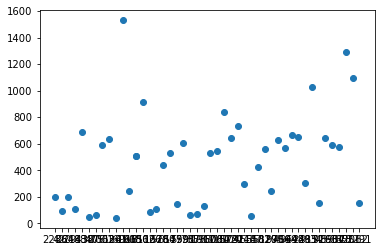

In [231]:
plt.scatter(df_prix['Distance à Paris (km)'],df_prix['Prix moyen du vol en $'])


In [235]:
model_acp=PCA()
coeff_acp=model_acp.fit_transform(df_acp)

comp1=coeff_acp[:,0]
comp2=coeff_acp[:,1]

coeff_corr, pvalue=pearsonr(comp1,comp2)
print(coeff_corr, pvalue) #il n'y a plus de corrélation entre les composantes principales

1.3877787807814457e-17 1.0000000000058695


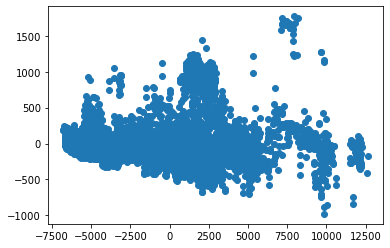

In [236]:
plt.scatter(comp1,comp2)
plt.show()

## Visualisation <a name = "paragraphe4"></a>

On utilise une partie de ce qui a déjà été fait dans la partie de statistqiues descriptives sur la destination du vol.

In [237]:
df_paris

,originAirportShortName,departd,returnd,airline,flightInfo.priceUSD,flightMaxStops,airport.latitude,airport.longitude,airport.shortName,city.name,country.name,distance
0,CDG,20220201,20220301,Multiple Airlines,322.97,0,40.750960,-73.987410,NYC,New York,United States,5829
3,ORY,20220201,20220301,Multiple Airlines,301.28,0,40.750960,-73.987410,NYC,New York,United States,5829
6,CDG,20220201,20220301,Multiple Airlines,68.95,0,51.507350,-0.127660,LON,London,United Kingdom,343
9,ORY,20220201,20220301,Multiple Airlines,67.74,0,51.507350,-0.127660,LON,London,United Kingdom,343
11,CDG,20220201,20220301,Multiple Airlines,381.85,0,25.796521,-80.286617,MIA,Miami,United States,7356
...,...,...,...,...,...,...,...,...,...,...,...,...
14577,ORY,20220201,20220301,Multiple Airlines,2103.01,0,32.591800,110.907670,WDS,Shiyan,China,8529
14578,ORY,20220201,20220301,Multiple Airlines,2146.07,0,36.646700,119.119000,WEF,Weifang,China,8643
14579,ORY,20220201,20220301,Multiple Airlines,2137.48,0,32.070800,120.976000,NTG,Nantong,China,9154
14580,ORY,20220201,20220301,Multiple Airlines,2184.50,0,46.843400,130.465000,JMU,Jiamusi,China,8250


In [239]:
prix_m=[]
for ville in villes_en : 
    p=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].astype(int).mean()
    prix_m.append(round(p))

In [240]:
latitude=[]
for ville in villes_en:
    latitude.append(df_paris[df_paris['city.name']==ville]['airport.latitude'].iloc[0])
    longitude=[]
for ville in villes_en:
    longitude.append(df_paris[df_paris['city.name']==ville]['airport.longitude'].iloc[0])

In [241]:
liste_prix=np.array([villes_en,prix_m,latitude,longitude]).T
df_prix=pd.DataFrame(liste_prix)
df_prix.columns=['Ville','Prix moyen du vol en $','Latitude','Longitude']

In [242]:
df_prix.head()

,Ville,Prix moyen du vol en $,Latitude,Longitude
0,Agadir,198,30.325,-9.41307
1,Amsterdam,96,52.30736127010797,4.767146455078091
2,Antalya,196,36.89873,30.80046
3,Athens,112,37.93636,23.944470000000003
4,Bangkok,688,13.913579750656696,100.60606335449222


On a créé un dataframa qui contient le nom des villes, les prix moyen d'un vol en \$, la latitude, la longitude et le nombre de vols.

In [243]:
df_prix['Latitude']=df_prix['Latitude'].astype(float)
df_prix['Longitude']=df_prix['Longitude'].astype(float)
df_prix['Prix moyen du vol en $']=df_prix['Prix moyen du vol en $'].astype(int)

In [244]:
df_prix=df_prix.sort_values('Prix moyen du vol en $')

In [789]:
!pip install folium

In [245]:
import folium
from folium.plugins import MarkerCluster

In [246]:
df_prix['Couleur'] = pd.cut(df_prix['Prix moyen du vol en $'], bins=6,
                            labels=['green','yellow','orange','red','brown','black'])

In [247]:
#carte vide
world_map= folium.Map(tiles="cartodbpositron")
#pour chaque ville on crée un cercle et on lui fait correspondre un prix
radius = 10
popup_text = """Ville : {}<br>
                    Prix moyen d'un vol en $ : {}<br>"""
popup_text = popup_text.format(df_prix.iloc[0]['Ville'],
                                   df_prix.iloc[0]['Prix moyen du vol en $']
                                   )
folium.CircleMarker(location=[df_prix.iloc[0]['Latitude'],df_prix.iloc[0]['Longitude']],radius=radius,color='blue',
                    popup = popup_text,fill=True).add_to(world_map)
for i in range(1,len(df_prix)):
        lat = df_prix.iloc[i]['Latitude']
        long = df_prix.iloc[i]['Longitude']
        color = df_prix.iloc[i]['Couleur']
        popup_text = """Ville : {}<br>
                    Prix moyen d'un vol en $ : {}<br>"""
        popup_text = popup_text.format(df_prix.iloc[i]['Ville'],
                                   df_prix.iloc[i]['Prix moyen du vol en $']
                                   )
        folium.CircleMarker(location=[lat,long],radius=radius,popup= popup_text,color=color,fill =True).add_to(world_map)

world_map

Le vol le moins cher est en bleu. Les autres vols varient de vert à noir en passant par jaune, orange, rouge et brun.

On exporte notre notebook en html. 

(Le code ne troune encore une fois qu'en local, d'où la mise en commentaire.)

In [ ]:
#!jupyter nbconvert --to html projet_kayak.ipynb